In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from pathlib import Path

from sklearn.preprocessing import LabelEncoder

import subprocess
from IPython.display import display, HTML, clear_output
import warnings
warnings.simplefilter("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

In [2]:
%reload_ext autoreload
%autoreload 2

from pptoolbox.platform.automl import STRATIFIED_KFOLD
from pptoolbox.platform.automl.optuna_op.tuner import AutoOpt_v4

from pptoolbox.platform.automl.utils import cross_group_predict

from utilsbyryan import plot_confusion_matrix

# import data

In [3]:
data_dir = Path("../data/processed")
version = 'v2'
split = 'v2.0'
data_folder = data_dir / version / split


train_folder = data_folder / "train"
test_folder = data_folder / "test"

X_train = pd.read_csv(train_folder / "input.csv", index_col=0)
y_train = pd.read_csv(train_folder / "label.csv", index_col=0)
y_train_meta = pd.read_csv(train_folder / "meta.csv", index_col=0)

assert X_train.index.equals(y_train.index)
assert X_train.index.equals(y_train_meta.index)

X_test = pd.read_csv(test_folder / "input.csv", index_col=0)
y_test = pd.read_csv(test_folder / "label.csv", index_col=0)
y_test_meta = pd.read_csv(test_folder / "meta.csv", index_col=0)

assert X_test.index.equals(y_test.index)
assert X_test.index.equals(y_test_meta.index)

print(X_train.shape, y_train.shape, y_train_meta.shape)
print(X_test.shape, y_test.shape, y_test_meta.shape)

(4762, 191) (4762, 1) (4762, 9)
(2499, 191) (2499, 1) (2499, 9)


In [4]:
params_to_train = y_train.columns.tolist()
non_classify_params = []
params_to_train = [p for p in params_to_train if p not in non_classify_params]
params_to_train

['Grade']

# Classify

In [5]:
model_folder = Path("../models/") / version / split
model_folder.mkdir(parents=True, exist_ok=True)

Training model for Grade...


[I 2025-12-19 13:02:26,672] A new study created in RDB with name: Grade


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-12-19 13:02:29,743] Trial 0 finished with value: {'loss': 0.25053240589472503} and parameters: {'mask': 'NIR', 'preprocessor': 'Detrend', 'model': 'GaussianNB', 'dimred_step': 'no'}. Best is trial 0 with value: 0.25053240589472503.
[I 2025-12-19 13:02:30,638] Trial 1 finished with value: {'loss': 0.4313199401001916} and parameters: {'mask': 'NIR', 'preprocessor': 'SNV', 'model': 'SGD', 'model__alpha': 0.1767218232266506, 'model__l1_ratio': 0.17052412368729153, 'dimred_step': 'no'}. Best is trial 0 with value: 0.25053240589472503.
[I 2025-12-19 13:02:31,658] Trial 2 finished with value: {'loss': 0.43262325432735205} and parameters: {'mask': 'Full', 'preprocessor': 'SNV', 'model': 'SGD', 'model__alpha': 0.105260377776104, 'model__l1_ratio': 0.18485445552552704, 'dimred_step': 'yes', 'dimred_method': 'PCA', 'dimred__n_components': 31}. Best is trial 0 with value: 0.25053240589472503.
[I 2025-12-19 13:02:32,522] Trial 3 finished with value: {'loss': 0.2831140292435438} and paramete

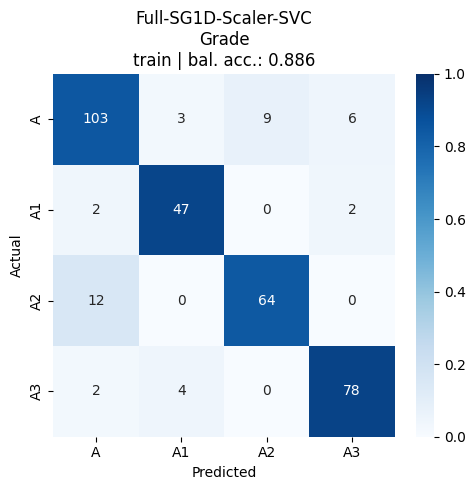

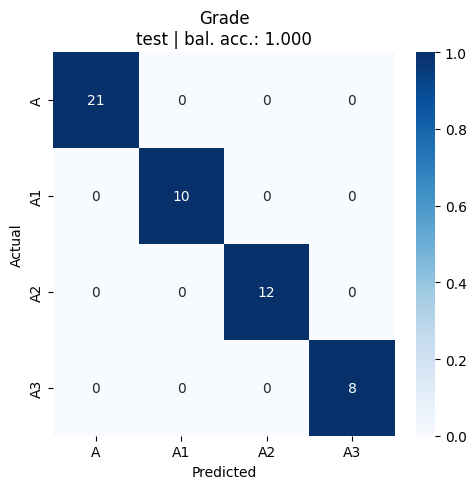

In [6]:
for i, param in enumerate(params_to_train):
    clear_output(wait=True)

    # if i !=0:
    #     # For testing purposes, only run the first parameter
    #     break

    param_folder = model_folder / param
    param_folder.mkdir(parents=True, exist_ok=True)
    STORAGE_URL = f"sqlite:///{param_folder}/model_training.db"

    selected_y_train = y_train[[param]].copy()
    selected_y_test = y_test[[param]].copy()

    model_name = f"{param}"

    if (param_folder / f"trainer.pkl").exists():
        print(f"Trainer for {param} already exists. Loading...")

        trainer = AutoOpt_v4.load(param_folder / f"trainer.pkl")
        pipeline = trainer.get_pipeline()
        pipeline_platform = trainer.get_pipeline_platform()

        with open(param_folder / "encoder.pkl", "rb") as f:
            encoder = pkl.load(f)
        selected_y_train_encoded = pd.Series(encoder.transform(selected_y_train), index=selected_y_train.index)
        selected_y_test_encoded = pd.Series(encoder.transform(selected_y_test), index=selected_y_test.index)

    else:
        print(f"Training model for {param}...")

        # Encode labels
        encoder = LabelEncoder()
        selected_y_train_encoded = pd.Series(encoder.fit_transform(selected_y_train), index=selected_y_train.index)
        selected_y_test_encoded = pd.Series(encoder.transform(selected_y_test), index=selected_y_test.index)
        with open(param_folder / "encoder.pkl", "wb") as f:
            pkl.dump(encoder, f)

        # Initialise AutoML model
        trainer = AutoOpt_v4(
            task_type="classify",
            model_name=model_name,
            storage=STORAGE_URL,
            metric_names = ["loss"],
            direction = ["minimize",],
            # n_startup_trials=10,
            # n_trials=25,
        )

        # Launch new dashboard
        dashboard_process = subprocess.Popen(
            ["optuna-dashboard", STORAGE_URL, "--port", "8080"]
        )
        display(HTML('<a href="http://localhost:8080" target="_blank">Open Optuna Dashboard</a>'))

        trainer.fit(
            X_train,
            selected_y_train_encoded,
            groups=selected_y_train_encoded.index,
            # repeat=3,
            )
        
        trainer.save(param_folder / f"trainer.pkl")

        pipeline = trainer.get_pipeline()

        with open(param_folder / "origin_model_prediction.pkl", "wb") as f:
            pkl.dump(pipeline, f)

    # get cv train
    y_train_pred_encoded = cross_group_predict(
        pipeline,
        X_train,
        selected_y_train_encoded,
        groups=selected_y_train_encoded.index,
        cv=STRATIFIED_KFOLD
    )

    train_cfm = plot_confusion_matrix(
        y_true = selected_y_train_encoded.reset_index().drop_duplicates().set_index('lot_id'),
        y_pred = y_train_pred_encoded.astype(int),
        encoder = encoder,
        param = "-".join(pipeline.named_steps.keys()) + "\n" + param,
        title = "train"
        )
    
    plt.savefig(param_folder / "train_cfm.png")
    plt.show()

    y_test_pred_encoded = pd.DataFrame(pipeline.predict_proba(X_test),index=X_test.index).groupby(X_test.index).median().idxmax(axis=1)
    test_cfm = plot_confusion_matrix(
        y_true = selected_y_test_encoded.reset_index().drop_duplicates().set_index('lot_id'),
        y_pred = y_test_pred_encoded.astype(int),
        encoder = encoder,
        param = param,
        title = "test"
    )

    plt.savefig(param_folder / "test_cfm.png")
    plt.show()
    plt.close()

# manual inspect

In [34]:
def inspect_trial(trainer, trial_number, X_train, selected_y_train_encoded):
    test_params = trainer.study.trials[trial_number].params
    test_pipeline = construct_pipeline_from_params("classify",test_params)
    test_pipeline.fit(X_train, selected_y_train_encoded)

    # get cv train
    y_train_pred_encoded = cross_group_predict(
        test_pipeline,
        X_train,
        selected_y_train_encoded,
        groups=selected_y_train_encoded.index,
        cv=STRATIFIED_KFOLD
    )

    train_cfm = plot_confusion_matrix(
        y_true = selected_y_train_encoded.reset_index().drop_duplicates().set_index('lot_id'),
        y_pred = y_train_pred_encoded.astype(int),
        class_labels = encoder.classes_,
        param = "-".join(test_pipeline.named_steps.keys()) + "\n" + param,
        title = "train"
        )

    y_test_pred_encoded = pd.Series(test_pipeline.predict(X_test),index=X_test.index).groupby(X_test.index).median()
    test_cfm = plot_confusion_matrix(
        y_true = selected_y_test_encoded.reset_index().drop_duplicates().set_index('lot_id'),
        y_pred = y_test_pred_encoded.astype(int),
        class_labels = encoder.classes_,
        param = param,
        title = "test"
    )


In [58]:
def change_best_trial(trainer, trial_number, X_train, selected_y_train_encoded, param_folder):

    trainer.set_manual_best_trial(trial_number, X_train, selected_y_train_encoded)

    trainer.save(param_folder / f"trainer.pkl")

    pipeline = trainer.get_pipeline()
    with open(param_folder / "pipeline_full.pkl", "wb") as f:
        pkl.dump(pipeline, f)

    pipeline_platform = trainer.get_pipeline_platform()
    with open(param_folder / "origin_model_prediction.pkl", "wb") as f:
        pkl.dump(pipeline_platform, f)

    # get cv train
    y_train_pred_encoded = cross_group_predict(
        pipeline,
        X_train,
        selected_y_train_encoded,
        groups=selected_y_train_encoded.index,
        cv=STRATIFIED_KFOLD
    )

    train_cfm = plot_confusion_matrix(
        y_true = selected_y_train_encoded.reset_index().drop_duplicates().set_index('lot_id'),
        y_pred = y_train_pred_encoded.astype(int),
        class_labels = encoder.classes_,
        param = "-".join(pipeline.named_steps.keys()) + "\n" + param,
        title = "train"
        )

    train_cfm.savefig(param_folder / "train_cfm.png", bbox_inches='tight')

    y_test_pred_encoded = pd.Series(pipeline.predict(X_test),index=X_test.index).groupby(X_test.index).median()
    test_cfm = plot_confusion_matrix(
        y_true = selected_y_test_encoded.reset_index().drop_duplicates().set_index('lot_id'),
        y_pred = y_test_pred_encoded.astype(int),
        class_labels = encoder.classes_,
        param = param,
        title = "test"
    )

    test_cfm.savefig(param_folder / "test_cfm.png", bbox_inches='tight')